In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/PAC/cnn

Mounted at /content/drive
/content/drive/MyDrive/Github/PAC/cnn


In [1]:
import data
import aimodel
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.color import label2rgb

In [4]:
img, lbl = data.get_random(seed=4)
height, width = lbl.shape
img = tf.convert_to_tensor(img[np.newaxis, :, :, np.newaxis])
lbl = tf.convert_to_tensor(lbl[np.newaxis, :, :, np.newaxis].astype(float))
assert img.shape == lbl.shape == (1, height, width, 1)

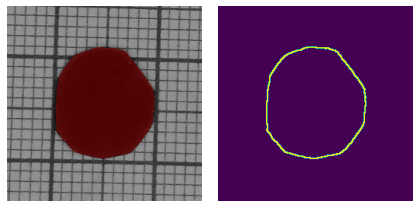

In [5]:
edge = tf.reduce_any(tf.image.sobel_edges(lbl) != 0, axis=-1)[0, :, :, 0]
assert edge.shape == (height, width)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.imshow(label2rgb(lbl[0, :, :, 0].numpy(), img[0, :, :, 0].numpy(), bg_label=0)); ax1.axis('off')
ax2.imshow(edge); ax2.axis('off')

fig.tight_layout()
plt.show()

In [6]:
X, Y = tf.meshgrid(tf.range(width, dtype=float), tf.range(height, dtype=float))
Ex = X[edge][tf.newaxis, tf.newaxis, :] # Ex.shape = [1, 1, edge_pixels]
Ey = Y[edge][tf.newaxis, tf.newaxis, :] # Ey.shape = [1, 1, edge_pixels]
R = tf.sqrt((Ex - X[:, :, tf.newaxis])**2 + (Ey - Y[:, :, tf.newaxis])**2)
assert R.shape == (height, width, Ex.shape[-1])
Ex.shape, Ey.shape, R.shape

(TensorShape([1, 1, 1117]),
 TensorShape([1, 1, 1117]),
 TensorShape([256, 256, 1117]))

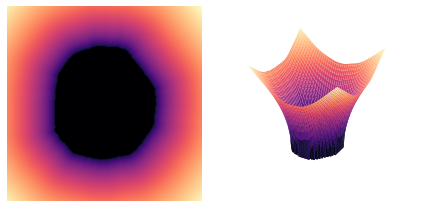

In [7]:
W = 1 + norm(tf.sqrt(tf.reduce_min(tf.where(lbl == 0, R, 0), axis=-1)))[0]

fig = plt.figure(figsize=(6, 3))
ax1 = fig.add_subplot(121); ax1.axis('off')
ax2 = fig.add_subplot(122, projection='3d'); ax2.axis('off')

ax1.imshow(W, cmap='magma')
ax2.plot_surface(X, Y, W, cmap='magma')

fig.tight_layout()
plt.show()

In [2]:
%%time
N = 8
imgs, lbls = data.get_random(N, as_tensor=True)
Ws = data.weights(lbls)
Ws.shape

CPU times: total: 1min 52s
Wall time: 1min 35s


TensorShape([8, 256, 256, 1])

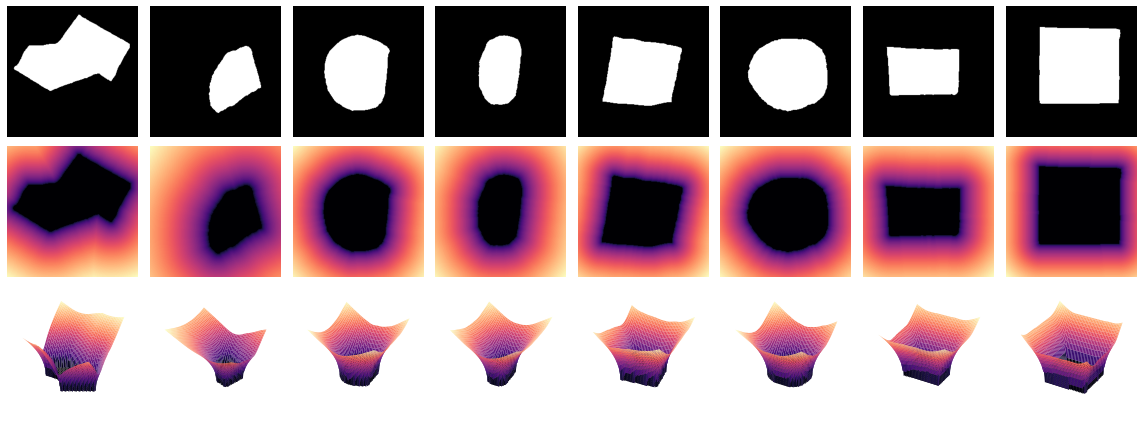

In [3]:
fig = plt.figure(figsize=(2*N, 6))

for i in range(N):
    ax1 = fig.add_subplot(3, N, i + 1); ax1.axis('off')
    ax2 = fig.add_subplot(3, N, i + N + 1); ax2.axis('off')
    ax3 = fig.add_subplot(3, N, i + 2*N + 1, projection='3d'); ax3.axis('off')

    lbl = tf.squeeze(lbls[i%N])
    w = tf.squeeze(Ws[i%N])
    ax1.imshow(lbl, cmap='gray')
    ax2.imshow(w, cmap='magma')
    ax3.plot_surface(*np.meshgrid(np.arange(lbls.shape[2]), np.arange(lbls.shape[1])), w, cmap='magma')

fig.tight_layout()
plt.show()

In [11]:
(x_train, y_train), (x_test, y_test) = data.load_dataset(as_tensor=True, augmentation=False)

In [12]:
Y_train = tf.stack((get_weight(tf.convert_to_tensor(y_train.astype(float)))[:, :, :, tf.newaxis], y_train), axis=1)
Y_test = tf.stack((get_weight(tf.convert_to_tensor(y_test.astype(float)))[:, :, :, tf.newaxis], y_test), axis=1)
Y_train.shape, Y_test.shape

(TensorShape([47, 2, 256, 256, 1]), TensorShape([16, 2, 256, 256, 1]))

In [ ]:
class Loss (tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    
    def call(self, y_true, y_pred):
        w = y_true[:, 0, :, :, :]
        lbl = y_true[:, 1, :, :, :]
        N = tf.multiply(*tf.cast(y_pred.shape, float)[1:-1])/tf.reduce_sum(y_pred, axis=(1, 2, 3))
        return tf.reduce_mean(w[:, :, :, 0]*tf.keras.metrics.binary_crossentropy(lbl, y_pred), axis=(1, 2))*N

In [ ]:
unet = aimodel.build_unet((256, 256, 1), (16, 32, 64))
unet.compile(optimizer=tf.keras.optimizers.Adam(), loss=Loss())

In [ ]:
tf.config.run_functions_eagerly(True)
history = unet.fit(x_train, Y_train, epochs=150, batch_size=len(x_train)//6, validation_data=(x_test, Y_test))

Epoch 1/150


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7/7 [==============================] - 33s 5s/step - loss: 1.8976 - val_loss: 1.9939
Epoch 2/150
7/7 [==============================] - 25s 4s/step - loss: 1.3719 - val_loss: 1.9799
Epoch 3/150
7/7 [==============================] - 25s 4s/step - loss: 1.0760 - val_loss: 2.0574
Epoch 4/150
7/7 [==============================] - 25s 4s/step - loss: 0.9256 - val_loss: 2.5589
Epoch 5/150
7/7 [==============================] - 27s 4s/step - loss: 0.8307 - val_loss: 3.4297
Epoch 6/150
7/7 [==============================] - 25s 4s/step - loss: 0.7711 - val_loss: 4.1132
Epoch 7/150
7/7 [==============================] - 26s 4s/step - loss: 0.7143 - val_loss: 4.6641
Epoch 8/150
7/7 [==============================] - 26s 4s/step - loss: 0.6742 - val_loss: 5.7943
Epoch 9/150
7/7 [==============================] - 25s 4s/step - loss: 0.6278 - val_loss: 5.6752
Epoch 10/150
7/7 [==============================] - 26s 4s/step - loss: 0.5949 - val_loss: 6.3688
Epoch 11/150
7/7 [=======================

[]

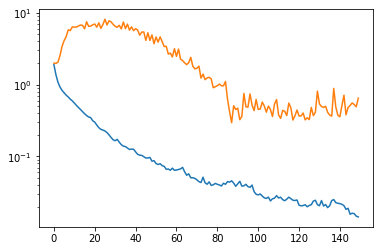

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.semilogy()

In [13]:
class Loss2 (tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    
    def call(self, y_true, y_pred):
        w = y_true[:, 0, :, :, :]
        lbl = y_true[:, 1, :, :, :]
        Ap_true = tf.reduce_sum(lbl, axis=(1, 2, 3))
        Ap_pred = tf.reduce_sum(y_pred, axis=(1, 2, 3))
        N = tf.multiply(*tf.cast(y_pred.shape, float)[1:-1])/Ap_pred
        WB = tf.reduce_mean(w[:, :, :, 0]*tf.keras.losses.binary_crossentropy(lbl, y_pred), axis=(1, 2))*N
        MP = tf.losses.MAPE(Ap_true, Ap_pred)*1e-2
        return WB + MP

In [14]:
unet = aimodel.build_unet((256, 256, 1), (16, 32, 64))
unet.compile(optimizer=tf.keras.optimizers.Adam(), loss=Loss2())

In [15]:
tf.config.run_functions_eagerly(True)
history = unet.fit(x_train, Y_train, epochs=150, batch_size=len(x_train)//6, validation_data=(x_test, Y_test))

Epoch 1/150


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7/7 [==============================] - 30s 4s/step - loss: 3.4305 - val_loss: 3.7027
Epoch 2/150
7/7 [==============================] - 29s 4s/step - loss: 2.8076 - val_loss: 3.8403
Epoch 3/150
7/7 [==============================] - 29s 4s/step - loss: 2.3288 - val_loss: 4.5384
Epoch 4/150
7/7 [==============================] - 29s 4s/step - loss: 2.0882 - val_loss: 5.8299
Epoch 5/150
7/7 [==============================] - 29s 4s/step - loss: 1.8757 - val_loss: 7.5298
Epoch 6/150
7/7 [==============================] - 29s 4s/step - loss: 1.7567 - val_loss: 9.1441
Epoch 7/150
7/7 [==============================] - 29s 4s/step - loss: 1.6598 - val_loss: 10.0271
Epoch 8/150
7/7 [==============================] - 29s 4s/step - loss: 1.5440 - val_loss: 9.5890
Epoch 9/150
7/7 [==============================] - 29s 4s/step - loss: 1.4827 - val_loss: 10.0762
Epoch 10/150
7/7 [==============================] - 29s 4s/step - loss: 1.3947 - val_loss: 10.9135
Epoch 11/150
7/7 [====================

[]

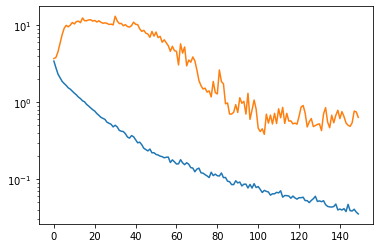

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.semilogy()